# **1. Understanding Seasonal Patterns in Electricity Consumption:**

Description: Analyze historical electricity load data to identify seasonal patterns and variations in consumption over different times, such as seasons or months. Break down the data to understand how it changes over time and use simple methods to identify the main repeating patterns.


# **FB - Prophet**

In [ ]:
import pandas as pd
from prophet import Prophet
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, \
    max_error, mean_poisson_deviance, mean_gamma_deviance, mean_tweedie_deviance, mean_absolute_percentage_error

In [ ]:
pip install catboost


In [ ]:
pip install optuna


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, \
    max_error, mean_poisson_deviance, mean_gamma_deviance, mean_tweedie_deviance, mean_absolute_percentage_error
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import optuna

from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K
import lightgbm as lgb

import gc


In [ ]:
# load all data
df = pd.read_csv('continuous dataset.csv',
                 index_col=[0],
                  parse_dates=[0])

In [ ]:
df.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [ ]:
#X = df.drop(columns = ['nat_demand','datetime'])

<Axes: xlabel='datetime'>

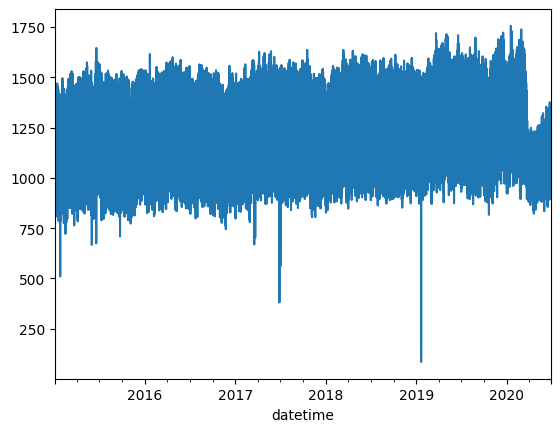

In [ ]:
df["nat_demand"].plot()

In [ ]:
from statistics import mean

print("Max: ",max(df["nat_demand"]))
print("Mean: ",mean(df["nat_demand"]))
print("Min: ",min(df["nat_demand"]))

Max:  1754.882
Mean:  1182.8686472323864
Min:  85.19250000000002


In [ ]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='nat_demand')
features_and_target = pd.concat([X, y], axis=1)

<ipython-input-10-e508e38e32d9>:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [ ]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,nat_demand
datetime,,,,,,,,,,,
2015-01-03 01:00:00,1,5,1,1,2015,3,3,1,Saturday,Winter,970.3450
2015-01-03 02:00:00,2,5,1,1,2015,3,3,1,Saturday,Winter,912.1755
2015-01-03 03:00:00,3,5,1,1,2015,3,3,1,Saturday,Winter,900.2688
2015-01-03 04:00:00,4,5,1,1,2015,3,3,1,Saturday,Winter,889.9538
2015-01-03 05:00:00,5,5,1,1,2015,3,3,1,Saturday,Winter,893.6865


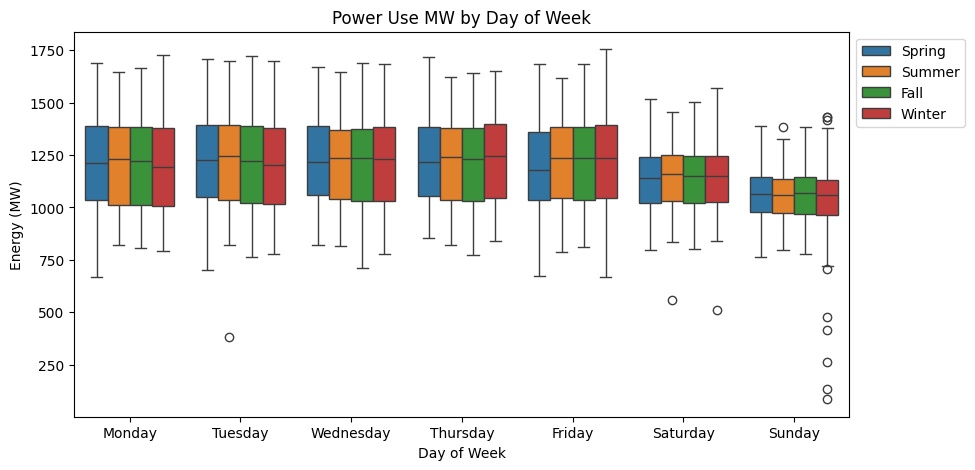

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='nat_demand',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
# Save the plot as a PNG file
plt.savefig('power_use_by_day_of_week.png', bbox_inches='tight')
plt.show()

In [ ]:
split_date = "1-Jan-2019"
train_df = df.loc[df.index <= split_date].copy()
test_df = df.loc[df.index > split_date].copy()

In [ ]:
print(f"Shape of train dataset: {train_df.shape}")
print(f"Shape of test dataset: {test_df.shape}")

Shape of train dataset: (35016, 16)
Shape of test dataset: (13032, 16)


In [ ]:
train_df

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 20:00:00,1241.6289,25.626184,0.017188,0.007753,23.396554,24.055872,0.016654,0.005663,10.329677,22.626184,0.015883,0.060974,6.390054,22,1,0
2018-12-31 21:00:00,1193.0323,25.398706,0.017038,0.003750,23.285532,23.875269,0.016672,0.007523,10.568211,22.414331,0.016000,0.059952,6.114301,22,1,0
2018-12-31 22:00:00,1137.6514,25.179926,0.017070,0.002913,22.767433,23.804926,0.016696,0.013668,11.376140,22.343988,0.016109,0.055725,6.074089,22,1,0


In [ ]:
test_df

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2019-01-01 01:00:00,1006.3692,24.839471,0.017123,0.008972,23.223214,23.519159,0.016452,0.014172,12.098985,22.066034,0.015872,0.079041,6.145190,1,1,0
2019-01-01 02:00:00,990.4364,24.862939,0.017205,0.011501,23.223043,23.402002,0.016335,0.012352,12.282677,21.980127,0.015694,0.080963,6.233335,1,1,0
2019-01-01 03:00:00,975.8917,24.886011,0.017333,0.012527,22.834583,23.300073,0.016196,0.007969,12.509328,21.886011,0.015506,0.080414,6.368042,1,1,0
2019-01-01 04:00:00,949.1626,24.932092,0.017439,0.012455,22.174321,23.166467,0.016096,0.007296,11.912222,21.838342,0.015379,0.078094,6.269188,1,1,0
2019-01-01 05:00:00,931.3311,24.945215,0.017620,0.011173,20.240084,23.070215,0.016056,0.007160,11.192411,21.867090,0.015339,0.077789,6.301165,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26 20:00:00,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,0.018381,0.150879,2.444658,0,0,1
2020-06-26 21:00:00,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,0.018320,0.156311,2.515814,0,0,1
2020-06-26 22:00:00,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,0.018327,0.153259,2.800717,0,0,1


In [ ]:
windows = [12, 24, 128]

new_columns = []

for column in train_df.columns:
    if column == 'nat_demand':
        for window in windows:
            new_columns.append(f"{column}_lag_{window}")
            new_columns.append(f"{column}_ma_mean{window}")
            new_columns.append(f"{column}_std_std{window}")
            new_columns.append(f"{column}_ewm_std{window}")
            new_columns.append(f"{column}_ewm_mean{window}")

    if column != 'datetime' and column != 'holiday' and column != 'school' and column != 'Holiday_ID' and column != 'nat_demand':
        for window in windows:
            new_columns.append(f"{column}_lag_{window}")
            new_columns.append(f"{column}_ma_mean{window}")
            new_columns.append(f"{column}_std_std{window}")
            new_columns.append(f"{column}_ewm_std{window}")
            new_columns.append(f"{column}_ewm_mean{window}")
            new_columns.append(f"{column}_min_max{window}")
            new_columns.append(f"{column}_median{window}")
            new_columns.append(f"{column}_skew{window}")
            new_columns.append(f"{column}_kurt{window}")
            new_columns.append(f"{column}_p50{window}")

new_df = pd.DataFrame(columns=new_columns)

for column in train_df.columns:
    if column == 'nat_demand':
        for window in windows:
            new_df[f"{column}_lag_{window}"] = train_df[column].shift(window)
            new_df[f"{column}_ma_mean{window}"] = train_df[column].rolling(window).mean()
            new_df[f"{column}_std_std{window}"] = train_df[column].rolling(window).std()
            new_df[f"{column}_ewm_std{window}"] = train_df[column].ewm(window).std()
            new_df[f"{column}_ewm_mean{window}"] = train_df[column].ewm(window).mean()

    if column != 'datetime' and column != 'holiday' and column != 'school' and column != 'Holiday_ID' and column != 'nat_demand':
        for window in windows:
            new_df[f"{column}_lag_{window}"] = train_df[column].shift(window)
            new_df[f"{column}_ma_mean{window}"] = train_df[column].rolling(window).mean()
            new_df[f"{column}_std_std{window}"] = train_df[column].rolling(window).std()
            new_df[f"{column}_ewm_std{window}"] = train_df[column].ewm(window).std()
            new_df[f"{column}_ewm_mean{window}"] = train_df[column].ewm(window).mean()
            new_df[f"{column}_min_max{window}"] = (train_df[column] -train_df[column].rolling(window).min()) / (train_df[column].rolling(window).max() - train_df[column].rolling(window).min())
            new_df[f"{column}_median{window}"] = train_df[column].rolling(window).median()
            new_df[f"{column}_skew{window}"] = train_df[column].rolling(window).skew()
            new_df[f"{column}_kurt{window}"] = train_df[column].rolling(window).kurt()
            new_df[f"{column}_p50{window}"] = train_df[column].rolling(window).quantile(0.5)

train_df = pd.concat([train_df, new_df], axis=1)


In [ ]:
train_df.dropna(inplace=True)

In [ ]:
train_df

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,...,W2M_dav_lag_128,W2M_dav_ma_mean128,W2M_dav_std_std128,W2M_dav_ewm_std128,W2M_dav_ewm_mean128,W2M_dav_min_max128,W2M_dav_median128,W2M_dav_skew128,W2M_dav_kurt128,W2M_dav_p50128
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-08 09:00:00,1275.1120,27.571802,0.016819,0.026474,33.521500,26.884302,0.017131,0.062561,18.893116,23.774927,...,5.364148,6.199112,1.491481,1.390388,6.439521,0.973497,6.394866,-0.567548,-0.519360,6.394866
2015-01-08 10:00:00,1348.9510,28.399377,0.016773,0.025772,33.816953,27.993127,0.017017,0.058289,19.903031,24.954065,...,5.572471,6.220771,1.502398,1.397702,6.462729,0.982404,6.464252,-0.575322,-0.525737,6.464252
2015-01-08 11:00:00,1365.6284,29.004724,0.016819,0.031982,33.338703,28.785974,0.017048,0.055099,19.899943,25.746912,...,5.871184,6.240072,1.513699,1.404431,6.485517,0.981865,6.485280,-0.579291,-0.539667,6.485280
2015-01-08 12:00:00,1343.4717,29.328638,0.016871,0.048721,32.322581,29.297388,0.017054,0.044006,19.667262,26.180200,...,5.883621,6.260305,1.526154,1.412813,6.509520,1.000000,6.503291,-0.580459,-0.552839,6.503291
2015-01-08 13:00:00,1371.5959,29.372705,0.016870,0.065063,31.365933,29.528955,0.016962,0.046646,19.495408,26.278955,...,5.611724,6.284000,1.539492,1.423564,6.535190,1.000000,6.522611,-0.582098,-0.556282,6.522611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 20:00:00,1241.6289,25.626184,0.017188,0.007753,23.396554,24.055872,0.016654,0.005663,10.329677,22.626184,...,6.977380,4.760650,1.474671,1.519445,4.915479,0.865830,4.849127,-0.882278,0.927637,4.849127
2018-12-31 21:00:00,1193.0323,25.398706,0.017038,0.003750,23.285532,23.875269,0.016672,0.007523,10.568211,22.414331,...,7.005403,4.753688,1.466068,1.517206,4.924772,0.824538,4.849127,-0.905845,0.965076,4.849127
2018-12-31 22:00:00,1137.6514,25.179926,0.017070,0.002913,22.767433,23.804926,0.016696,0.013668,11.376140,22.343988,...,7.024324,4.746265,1.456857,1.514685,4.933682,0.818517,4.849127,-0.931936,1.005247,4.849127


In [ ]:
test_df.nat_demand.to_csv('my_data.csv', index=False)

In [ ]:
new_columns = []
windows = [12, 24, 128]
for column in test_df.columns:
    if column == 'nat_demand':
        for window in windows:
            new_columns.append(f"{column}_lag_{window}")
            new_columns.append(f"{column}_ma_mean{window}")
            new_columns.append(f"{column}_std_std{window}")
            new_columns.append(f"{column}_ewm_std{window}")
            new_columns.append(f"{column}_ewm_mean{window}")

    if column != 'datetime' and column != 'holiday' and column != 'school' and column != 'Holiday_ID' and column != 'nat_demand':
        for window in windows:
            new_columns.append(f"{column}_lag_{window}")
            new_columns.append(f"{column}_ma_mean{window}")
            new_columns.append(f"{column}_std_std{window}")
            new_columns.append(f"{column}_ewm_std{window}")
            new_columns.append(f"{column}_ewm_mean{window}")
            new_columns.append(f"{column}_min_max{window}")
            new_columns.append(f"{column}_median{window}")
            new_columns.append(f"{column}_skew{window}")
            new_columns.append(f"{column}_kurt{window}")
            new_columns.append(f"{column}_p50{window}")

new_df = pd.DataFrame(columns=new_columns)

for column in test_df.columns:
    if column == 'nat_demand':
        for window in windows:
            new_df[f"{column}_lag_{window}"] = test_df[column].shift(window)
            new_df[f"{column}_ma_mean{window}"] = test_df[column].rolling(window).mean()
            new_df[f"{column}_std_std{window}"] = test_df[column].rolling(window).std()
            new_df[f"{column}_ewm_std{window}"] = test_df[column].ewm(window).std()
            new_df[f"{column}_ewm_mean{window}"] = test_df[column].ewm(window).mean()

    if column != 'datetime' and column != 'holiday' and column != 'school' and column != 'Holiday_ID' and column != 'nat_demand':
        for window in windows:
            new_df[f"{column}_lag_{window}"] = test_df[column].shift(window)
            new_df[f"{column}_ma_mean{window}"] = test_df[column].rolling(window).mean()
            new_df[f"{column}_std_std{window}"] = test_df[column].rolling(window).std()
            new_df[f"{column}_ewm_std{window}"] = test_df[column].ewm(window).std()
            new_df[f"{column}_ewm_mean{window}"] = test_df[column].ewm(window).mean()
            new_df[f"{column}_min_max{window}"] = (test_df[column] -test_df[column].rolling(window).min()) / (test_df[column].rolling(window).max() - test_df[column].rolling(window).min())
            new_df[f"{column}_median{window}"] = test_df[column].rolling(window).median()
            new_df[f"{column}_skew{window}"] = test_df[column].rolling(window).skew()
            new_df[f"{column}_kurt{window}"] = test_df[column].rolling(window).kurt()
            new_df[f"{column}_p50{window}"] = test_df[column].rolling(window).quantile(0.5)

test_df = pd.concat([test_df, new_df], axis=1)


In [ ]:
test_df.dropna(inplace=True)

In [ ]:
test_df

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,...,W2M_dav_lag_128,W2M_dav_ma_mean128,W2M_dav_std_std128,W2M_dav_ewm_std128,W2M_dav_ewm_mean128,W2M_dav_min_max128,W2M_dav_median128,W2M_dav_skew128,W2M_dav_kurt128,W2M_dav_p50128
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-06 09:00:00,1050.7971,27.411096,0.016399,0.031555,27.262736,27.270471,0.017185,0.014236,14.011013,24.934534,...,6.145190,4.560622,1.504904,1.459364,4.425393,0.540201,4.853817,-0.783848,0.116907,4.853817
2019-01-06 10:00:00,1100.5710,28.260309,0.016414,0.027863,27.282461,28.541559,0.017299,0.011993,14.315570,26.330621,...,6.233335,4.543838,1.498066,1.450892,4.421247,0.507997,4.842220,-0.771877,0.126300,4.842220
2019-01-06 11:00:00,1154.8653,28.903589,0.016452,0.027283,26.760379,29.512964,0.017390,0.011295,14.150185,27.434839,...,6.368042,4.523386,1.490818,1.443913,4.413109,0.454270,4.822929,-0.757241,0.127051,4.822929
2019-01-06 12:00:00,1168.6314,29.288812,0.016428,0.026230,26.304043,30.148187,0.017473,0.012177,13.900855,28.148187,...,6.269188,4.499522,1.487095,1.441138,4.398638,0.368330,4.788671,-0.732426,0.098339,4.788671
2019-01-06 13:00:00,1176.4999,29.395227,0.016321,0.025826,26.440123,30.442102,0.017481,0.014008,13.663632,28.442102,...,6.301165,4.470741,1.487602,1.445617,4.377220,0.272467,4.765342,-0.703123,0.038917,4.765342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26 20:00:00,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,...,1.519354,2.434515,0.858886,1.080783,2.716574,0.585725,2.437952,-0.269729,-0.461723,2.437952
2020-06-26 21:00:00,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,...,2.021437,2.438377,0.858125,1.076730,2.715018,0.605266,2.450098,-0.283265,-0.447758,2.450098
2020-06-26 22:00:00,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,...,2.240761,2.442752,0.858537,1.072575,2.715682,0.683506,2.457710,-0.297688,-0.446453,2.457710


In [ ]:
train_df_new=train_df

In [ ]:
train_df_new.index=train_df.index

In [ ]:
train_df_new

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,...,W2M_dav_lag_128,W2M_dav_ma_mean128,W2M_dav_std_std128,W2M_dav_ewm_std128,W2M_dav_ewm_mean128,W2M_dav_min_max128,W2M_dav_median128,W2M_dav_skew128,W2M_dav_kurt128,W2M_dav_p50128
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-08 09:00:00,1275.1120,27.571802,0.016819,0.026474,33.521500,26.884302,0.017131,0.062561,18.893116,23.774927,...,5.364148,6.199112,1.491481,1.390388,6.439521,0.973497,6.394866,-0.567548,-0.519360,6.394866
2015-01-08 10:00:00,1348.9510,28.399377,0.016773,0.025772,33.816953,27.993127,0.017017,0.058289,19.903031,24.954065,...,5.572471,6.220771,1.502398,1.397702,6.462729,0.982404,6.464252,-0.575322,-0.525737,6.464252
2015-01-08 11:00:00,1365.6284,29.004724,0.016819,0.031982,33.338703,28.785974,0.017048,0.055099,19.899943,25.746912,...,5.871184,6.240072,1.513699,1.404431,6.485517,0.981865,6.485280,-0.579291,-0.539667,6.485280
2015-01-08 12:00:00,1343.4717,29.328638,0.016871,0.048721,32.322581,29.297388,0.017054,0.044006,19.667262,26.180200,...,5.883621,6.260305,1.526154,1.412813,6.509520,1.000000,6.503291,-0.580459,-0.552839,6.503291
2015-01-08 13:00:00,1371.5959,29.372705,0.016870,0.065063,31.365933,29.528955,0.016962,0.046646,19.495408,26.278955,...,5.611724,6.284000,1.539492,1.423564,6.535190,1.000000,6.522611,-0.582098,-0.556282,6.522611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 20:00:00,1241.6289,25.626184,0.017188,0.007753,23.396554,24.055872,0.016654,0.005663,10.329677,22.626184,...,6.977380,4.760650,1.474671,1.519445,4.915479,0.865830,4.849127,-0.882278,0.927637,4.849127
2018-12-31 21:00:00,1193.0323,25.398706,0.017038,0.003750,23.285532,23.875269,0.016672,0.007523,10.568211,22.414331,...,7.005403,4.753688,1.466068,1.517206,4.924772,0.824538,4.849127,-0.905845,0.965076,4.849127
2018-12-31 22:00:00,1137.6514,25.179926,0.017070,0.002913,22.767433,23.804926,0.016696,0.013668,11.376140,22.343988,...,7.024324,4.746265,1.456857,1.514685,4.933682,0.818517,4.849127,-0.931936,1.005247,4.849127


In [ ]:
num_columns = len(test_df.columns)
num_columns

391

In [ ]:
df_train_prophet = train_df_new.reset_index() \
    .rename(columns={'datetime':'ds',
                     'nat_demand':'y'})

model_new = Prophet() #instantiate Prophet

for i in range(1,num_columns-1):
    model_new.add_regressor(train_df.columns[i])


'''
This code snippet prepares the training data (df_train_prophet)
for use with the Prophet model by resetting the index and renaming
the columns to match Prophet's expected format (ds for datetime and y for the target variable).
It then creates a new Prophet model (model_new) and iterates over the columns in train_df
(excluding the first and last columns) to add them as regressors to the model.
This allows the model to incorporate additional features into its forecast,
which can improve its accuracy by capturing the effects of these regressors on the target variable.

'''

"\nThis code snippet prepares the training data (df_train_prophet) \nfor use with the Prophet model by resetting the index and renaming \nthe columns to match Prophet's expected format (ds for datetime and y for the target variable). \nIt then creates a new Prophet model (model_new) and iterates over the columns in train_df \n(excluding the first and last columns) to add them as regressors to the model. \nThis allows the model to incorporate additional features into its forecast, \nwhich can improve its accuracy by capturing the effects of these regressors on the target variable.\n\n"

In [ ]:
df_train_prophet.head()

,ds,y,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,...,W2M_dav_lag_128,W2M_dav_ma_mean128,W2M_dav_std_std128,W2M_dav_ewm_std128,W2M_dav_ewm_mean128,W2M_dav_min_max128,W2M_dav_median128,W2M_dav_skew128,W2M_dav_kurt128,W2M_dav_p50128
0,2015-01-08 09:00:00,1275.1120,27.571802,0.016819,0.026474,33.521500,26.884302,0.017131,0.062561,18.893116,...,5.364148,6.199112,1.491481,1.390388,6.439521,0.973497,6.394866,-0.567548,-0.519360,6.394866
1,2015-01-08 10:00:00,1348.9510,28.399377,0.016773,0.025772,33.816953,27.993127,0.017017,0.058289,19.903031,...,5.572471,6.220771,1.502398,1.397702,6.462729,0.982404,6.464252,-0.575322,-0.525737,6.464252
2,2015-01-08 11:00:00,1365.6284,29.004724,0.016819,0.031982,33.338703,28.785974,0.017048,0.055099,19.899943,...,5.871184,6.240072,1.513699,1.404431,6.485517,0.981865,6.485280,-0.579291,-0.539667,6.485280
3,2015-01-08 12:00:00,1343.4717,29.328638,0.016871,0.048721,32.322581,29.297388,0.017054,0.044006,19.667262,...,5.883621,6.260305,1.526154,1.412813,6.509520,1.000000,6.503291,-0.580459,-0.552839,6.503291
4,2015-01-08 13:00:00,1371.5959,29.372705,0.016870,0.065063,31.365933,29.528955,0.016962,0.046646,19.495408,...,5.611724,6.284000,1.539492,1.423564,6.535190,1.000000,6.522611,-0.582098,-0.556282,6.522611


In [ ]:
datatypes = df_train_prophet.dtypes

datatypes

ds                    datetime64[ns]
y                            float64
T2M_toc                      float64
QV2M_toc                     float64
TQL_toc                      float64
                           ...      
W2M_dav_min_max128           float64
W2M_dav_median128            float64
W2M_dav_skew128              float64
W2M_dav_kurt128              float64
W2M_dav_p50128               float64
Length: 392, dtype: object

In [ ]:
%%time
model_new.fit(df_train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmphdewwpk5/xnmr8lqh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphdewwpk5/ornsp3x5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93373', 'data', 'file=/tmp/tmphdewwpk5/xnmr8lqh.json', 'init=/tmp/tmphdewwpk5/ornsp3x5.json', 'output', 'file=/tmp/tmphdewwpk5/prophet_modelz35wejui/prophet_model-20240328033739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:37:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:41:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 57.3 s, sys: 7.65 s, total: 1min 4s
Wall time: 4min 39s


In [ ]:

test_df.dropna(inplace=True)

In [ ]:
test_df.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,...,W2M_dav_lag_128,W2M_dav_ma_mean128,W2M_dav_std_std128,W2M_dav_ewm_std128,W2M_dav_ewm_mean128,W2M_dav_min_max128,W2M_dav_median128,W2M_dav_skew128,W2M_dav_kurt128,W2M_dav_p50128
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-06 09:00:00,1050.7971,27.411096,0.016399,0.031555,27.262736,27.270471,0.017185,0.014236,14.011013,24.934534,...,6.145190,4.560622,1.504904,1.459364,4.425393,0.540201,4.853817,-0.783848,0.116907,4.853817
2019-01-06 10:00:00,1100.5710,28.260309,0.016414,0.027863,27.282461,28.541559,0.017299,0.011993,14.315570,26.330621,...,6.233335,4.543838,1.498066,1.450892,4.421247,0.507997,4.842220,-0.771877,0.126300,4.842220
2019-01-06 11:00:00,1154.8653,28.903589,0.016452,0.027283,26.760379,29.512964,0.017390,0.011295,14.150185,27.434839,...,6.368042,4.523386,1.490818,1.443913,4.413109,0.454270,4.822929,-0.757241,0.127051,4.822929
2019-01-06 12:00:00,1168.6314,29.288812,0.016428,0.026230,26.304043,30.148187,0.017473,0.012177,13.900855,28.148187,...,6.269188,4.499522,1.487095,1.441138,4.398638,0.368330,4.788671,-0.732426,0.098339,4.788671
2019-01-06 13:00:00,1176.4999,29.395227,0.016321,0.025826,26.440123,30.442102,0.017481,0.014008,13.663632,28.442102,...,6.301165,4.470741,1.487602,1.445617,4.377220,0.272467,4.765342,-0.703123,0.038917,4.765342


In [ ]:
df_test_prophet = test_df.reset_index() \
    .rename(columns={'datetime':'ds',
                     'nat_demand':'y'})

df_test_fcst = model_new.predict(df_test_prophet)

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1272: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['trend'] = self.predict_trend(df)


In [ ]:
df_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Holiday_ID,Holiday_ID_lower,Holiday_ID_upper,QV2M_dav,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-06 09:00:00,1170.375463,1055.321239,1130.202734,1170.375463,1170.375463,-0.063179,-0.063179,-0.063179,-3.318031,...,-22.867744,-22.867744,-22.867744,0.313180,0.313180,0.313180,0.0,0.0,0.0,1091.582309
1,2019-01-06 10:00:00,1170.375801,1070.738900,1143.449654,1170.375801,1170.375801,-0.063179,-0.063179,-0.063179,-3.334412,...,-21.572644,-21.572644,-21.572644,0.319351,0.319351,0.319351,0.0,0.0,0.0,1106.937200
2,2019-01-06 11:00:00,1170.376139,1079.580709,1152.227119,1170.376139,1170.376139,-0.063179,-0.063179,-0.063179,-3.365275,...,-20.122132,-20.122132,-20.122132,0.325550,0.325550,0.325550,0.0,0.0,0.0,1113.502435
3,2019-01-06 12:00:00,1170.376477,1079.434098,1154.091484,1170.376477,1170.376477,-0.063179,-0.063179,-0.063179,-3.038349,...,-18.527765,-18.527765,-18.527765,0.331779,0.331779,0.331779,0.0,0.0,0.0,1117.293967
4,2019-01-06 13:00:00,1170.376814,1084.289349,1158.751539,1170.376814,1170.376814,-0.063179,-0.063179,-0.063179,-2.241641,...,-16.802678,-16.802678,-16.802678,0.338036,0.338036,0.338036,0.0,0.0,0.0,1121.581185


In [ ]:
datatypes = df_test_fcst.dtypes
datatypes

ds                            datetime64[ns]
trend                                float64
yhat_lower                           float64
yhat_upper                           float64
trend_lower                          float64
                                   ...      
yearly_upper                         float64
multiplicative_terms                 float64
multiplicative_terms_lower           float64
multiplicative_terms_upper           float64
yhat                                 float64
Length: 1192, dtype: object

In [ ]:
df_test_fcst.yhat_lower

0        1055.321239
1        1070.738900
2        1079.580709
3        1079.434098
4        1084.289349
            ...     
12899    1151.634616
12900    1139.673807
12901    1098.836347
12902    1042.421476
12903    1003.066687
Name: yhat_lower, Length: 12904, dtype: float64

In [ ]:
df_test_fcst.describe()


,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Holiday_ID,Holiday_ID_lower,Holiday_ID_upper,QV2M_dav,QV2M_dav_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
count,12904.000000,12904.000000,12904.000000,12904.000000,12904.000000,12904.000000,12904.000000,12904.000000,12904.000000,12904.000000,...,12904.000000,12904.000000,12904.000000,12904.000000,12904.000000,12904.000000,12904.0,12904.0,12904.0,12904.000000
mean,1172.554450,1193.266109,1269.583992,1165.356203,1179.658655,-0.006994,-0.006994,-0.006994,-0.407108,-0.407108,...,0.038255,0.038255,0.038255,0.455307,0.455307,0.455307,0.0,0.0,0.0,1231.450611
std,1.258185,180.074524,179.644432,4.303210,6.729251,0.252596,0.252596,0.252596,3.449472,3.449472,...,17.745887,17.745887,17.745887,2.510050,2.510050,2.510050,0.0,0.0,0.0,179.858362
min,1170.375463,197.083352,273.110248,1156.320648,1170.375463,-0.063179,-0.063179,-0.063179,-12.648924,-12.648924,...,-28.337772,-28.337772,-28.337772,-3.279391,-3.279391,-3.279391,0.0,0.0,0.0,235.945713
25%,1171.464957,1047.470836,1124.098123,1161.692971,1173.502079,-0.063179,-0.063179,-0.063179,-2.920815,-2.920815,...,-17.407185,-17.407185,-17.407185,-1.300387,-1.300387,-1.300387,0.0,0.0,0.0,1085.672789
50%,1172.554450,1170.134738,1247.249839,1166.481421,1178.909270,-0.063179,-0.063179,-0.063179,0.250740,0.250740,...,3.082080,3.082080,3.082080,0.043710,0.043710,0.043710,0.0,0.0,0.0,1208.748082
75%,1173.643943,1320.791025,1397.124547,1169.364954,1185.334193,-0.063179,-0.063179,-0.063179,2.257331,2.257331,...,16.979083,16.979083,16.979083,1.316992,1.316992,1.316992,0.0,0.0,0.0,1358.822786
max,1174.733437,1682.015739,1758.810824,1170.519829,1192.978468,1.841096,1.841096,1.841096,8.086084,8.086084,...,23.842612,23.842612,23.842612,7.568010,7.568010,7.568010,0.0,0.0,0.0,1721.106615


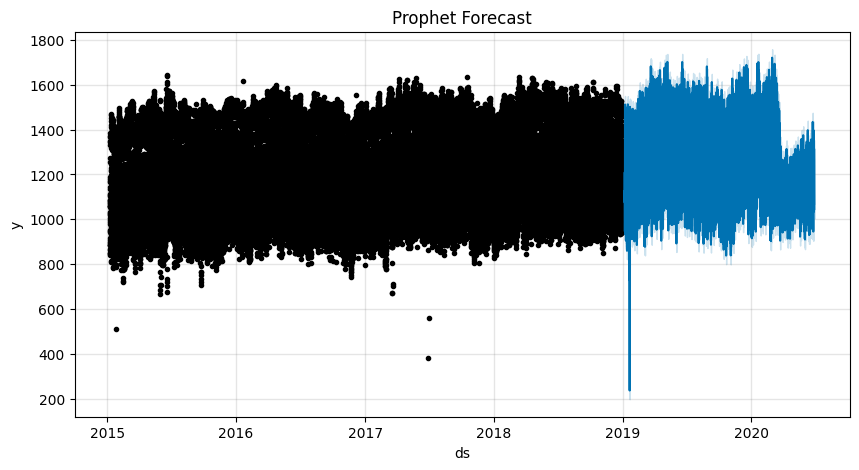

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model_new.plot(df_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.savefig('prophet_forecast.png', bbox_inches='tight')
plt.show()

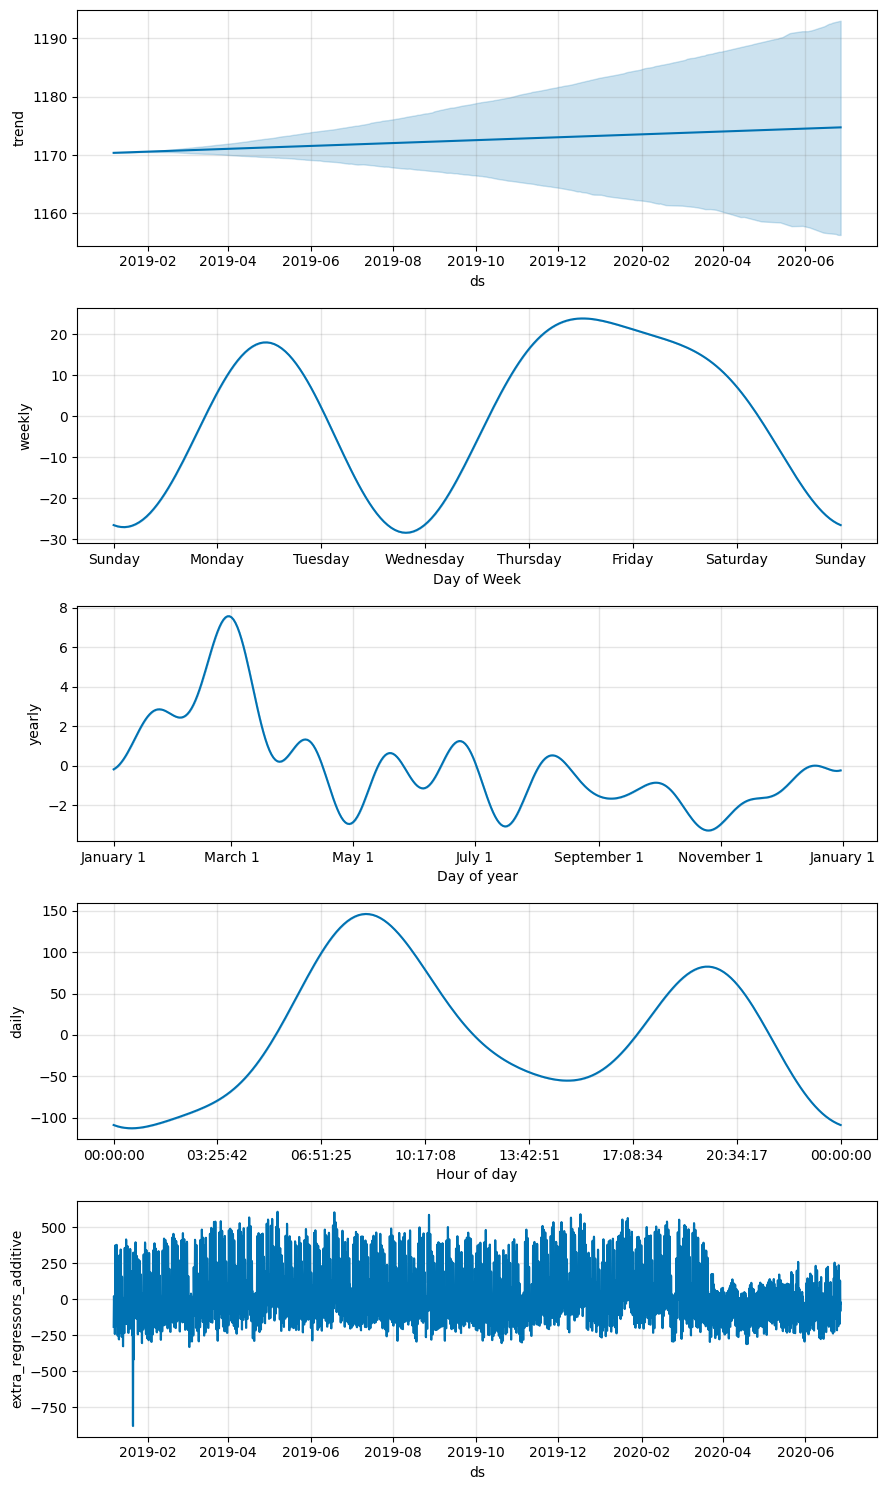

In [ ]:
fig = model_new.plot_components(df_test_fcst)
#plt.show()

**Graph Explanation :**

**Trend :** The trend analysis of the Facebook Prophet model reveals a consistent and noticeable increase in electricity consumption over time. This upward trend suggests a growing demand for electricity, which could be attributed to factors such as economic growth, population expansion, and technological advancements. Understanding this increasing trend is crucial for effective energy management and planning to meet future demand.

**Weekly:** It shows that at the start it starts picking up for the demand and deasing into the middle of the week and then peeks again on Thursday and decases gradually thought out the weekend.

**Daily:** Generally there is high demand in between the hours of 6:51 till 10:51 am in the morning, and it gradually decreases and starts peeking up slightly at the evenign hours around 6:30 pm till 9:00 pm.

**Yearly:** From the start of January till around mid April there is high demand , it could be becuase of the weather for heaters.

**Extra regressor additive:** this shows the other features of the dataset and thier general influence on the demand.

# Compare Forecast to Actuals

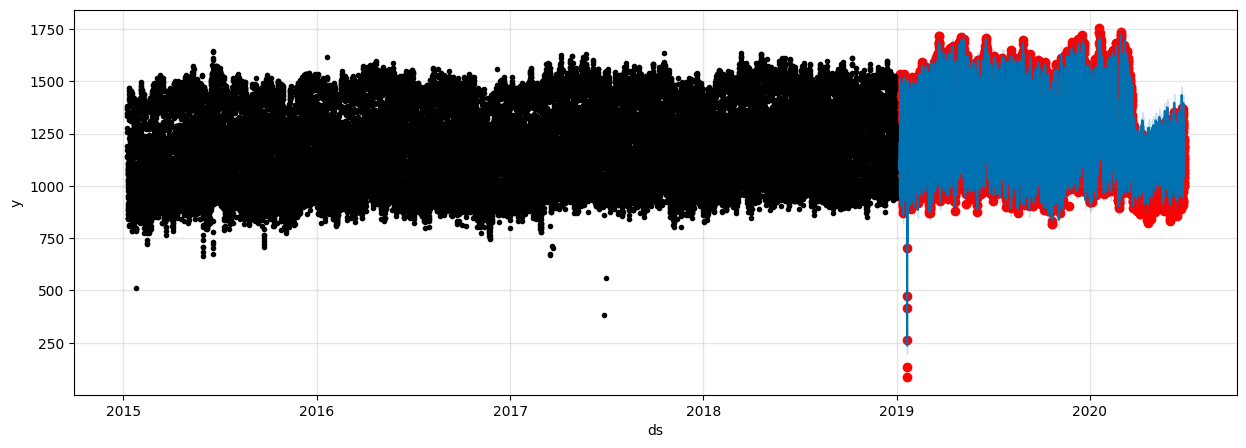

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test_df.index, test_df['nat_demand'], color='r')
fig = model_new.plot(df_test_fcst, ax=ax)

# Save the figure
plt.savefig('forecast_plot.png')

# Display the plot
plt.show()


In [ ]:
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [ ]:
len(df_test_fcst)

12904

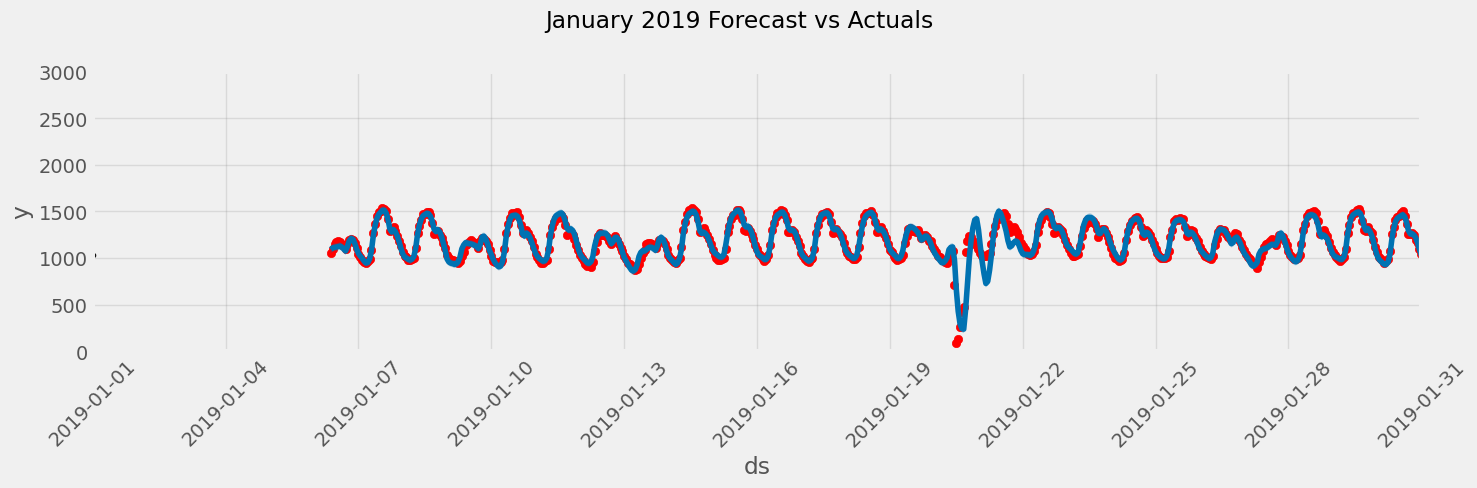

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test_df.index, test_df['nat_demand'], color='r')
fig = model_new.plot(df_test_fcst, ax=ax)
ax.set_xbound(lower=pd.to_datetime('1-01-2019'), upper=pd.to_datetime('1-31-2019'))
ax.set_ylim(0, 3000)
ax.tick_params(axis='x', rotation=45)
plot = plt.suptitle('January 2019 Forecast vs Actuals')
plt.tight_layout()  # Adjust the plot to prevent clipping of labels
plt.savefig(f'forecast_Jan_2019.png', bbox_inches='tight')

plt.show()




# Error

**Error Analysis**

**RMSE** (Root Mean Squared Error): The RMSE value of 41.832 indicates the square root of the average squared difference between the predicted and true values. It provides a measure of how well the model's predictions match the actual values, with lower values indicating better performance.

**MAE** (Mean Absolute Error): The MAE value of 30.021 represents the average absolute difference between the predicted and true values. It provides a measure of the magnitude of the errors in the predictions, regardless of their direction.

**MAPE** (Mean Absolute Percentage Error): The MAPE value of 0.026 indicates the average percentage difference between the predicted and true values. It provides a measure of the accuracy of the predictions relative to the actual values, with lower values indicating better accuracy.

In [ ]:
np.sqrt(mean_squared_error(y_true=test_df['nat_demand'],
                   y_pred=df_test_fcst['yhat']))

41.83200928898462

In [ ]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [ ]:
MAE(y_true=test_df['nat_demand'],
                   y_pred=df_test_fcst['yhat'])

30.021426604982953

In [ ]:
MAPE(y_true=test_df['nat_demand'],
                   y_pred=df_test_fcst['yhat'])

0.026662622371844646

In [ ]:
date= test_df.index.copy()
y_true=test_df['nat_demand'].values
y_pred=df_test_fcst['yhat'].values

In [ ]:
y_true.size

12904

In [ ]:
y_pred.size

12904

In [ ]:
type(y_pred)

numpy.ndarray

In [ ]:
array1 = y_true
array2 = y_pred
array3 = date

# Create a DataFrame by merging the arrays
data = {'Date':date,'Actual': array1, 'Prophet_Prediction': array2}
df_prophet_prediction = pd.DataFrame(data)

In [ ]:
df_prophet_prediction

,Date,Actual,Prophet_Prediction
0,2019-01-06 09:00:00,1050.7971,1091.582309
1,2019-01-06 10:00:00,1100.5710,1106.937200
2,2019-01-06 11:00:00,1154.8653,1113.502435
3,2019-01-06 12:00:00,1168.6314,1117.293967
4,2019-01-06 13:00:00,1176.4999,1121.581185
...,...,...,...
12899,2020-06-26 20:00:00,1128.5592,1192.184132
12900,2020-06-26 21:00:00,1112.7488,1183.062970
12901,2020-06-26 22:00:00,1081.5680,1140.369671
12902,2020-06-26 23:00:00,1041.6240,1084.333401


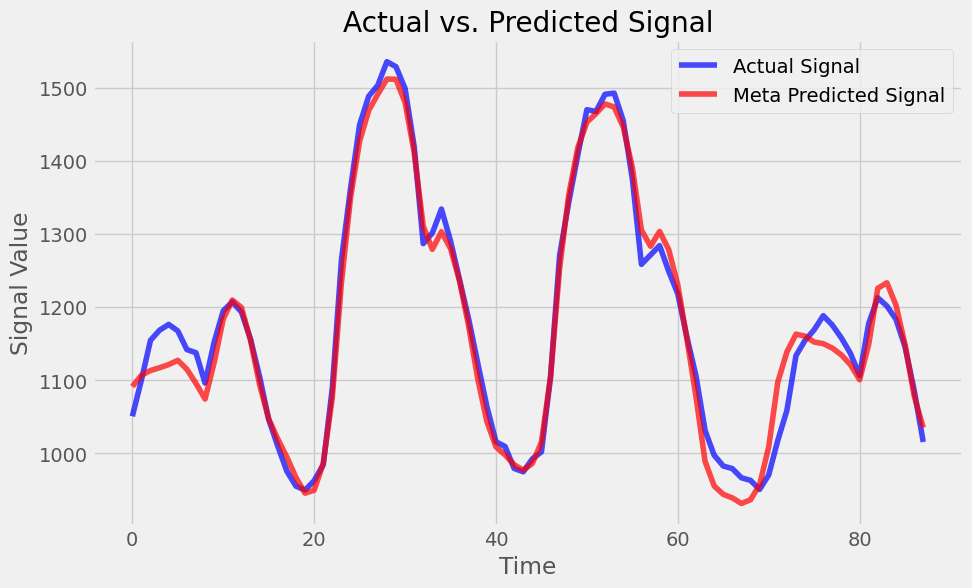

In [ ]:
y_test_pp= df_prophet_prediction.loc[df_prophet_prediction.Date<='2019-01-10' , 'Actual']
predictions_pp= df_prophet_prediction.loc[df_prophet_prediction.Date<='2019-01-10', 'Prophet_Prediction']
timestamps = range(len(y_test_pp))

plt.figure(figsize=(10, 6))
plt.plot(timestamps, y_test_pp, label='Actual Signal', color='blue', alpha = 0.7)
plt.plot(timestamps, predictions_pp, label='Meta Predicted Signal', color='red', alpha = 0.7)

plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.title('Actual vs. Predicted Signal')
plt.legend()
plt.savefig('Predictions')
plt.show()

In [ ]:
df_prophet_prediction.to_csv('predictions_Prophet.csv')

In [ ]:
y_test=y_true
predictions= y_pred

In [ ]:
rmse_test = mean_squared_error(y_test, predictions, squared=False)
mae_test = mean_absolute_error(y_test, predictions)
r2_test = r2_score(y_test, predictions)
explained_variance = explained_variance_score(y_test, predictions)
max_err = max_error(y_test, predictions)
poisson_deviance = mean_poisson_deviance(y_test, predictions)
gamma_deviance = mean_gamma_deviance(y_test, predictions)
tweedie_deviance = mean_tweedie_deviance(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"RMSE on test data: {rmse_test}")
print(f"MAE on test data: {mae_test}")
print("Mean Absolute Percentage Error:", mape)
print(f"R-squared on test data: {r2_test}")
print(f"Explained Variance on test data: {explained_variance}")
print(f"Max Error on test data: {max_err}")
print(f"Mean Poisson Deviance on test data: {poisson_deviance}")
print(f"Mean Gamma Deviance on test data: {gamma_deviance}")
print(f"Mean Tweedie Deviance on test data: {tweedie_deviance}")

RMSE on test data: 41.83200928898462
MAE on test data: 30.021426604982953
Mean Absolute Percentage Error: 0.026662622371844646
R-squared on test data: 0.9505474413595788
Explained Variance on test data: 0.9542734696237758
Max Error on test data: 622.0284645411687
Mean Poisson Deviance on test data: 1.6150852046912958
Mean Gamma Deviance on test data: 0.0017068578312102929
Mean Tweedie Deviance on test data: 1749.9170011536955


# **Conlusion and anaysis**:

From the output results and the provided table, we can see that the Prophet model's predictions are generally close to the actual values. The mean squared error (MSE) between the actual and predicted values is approximately 41.83, indicating a relatively low error rate. The mean absolute error (MAE) is around 30.02, showing that, on average, the model's predictions are off by about 30 units. The mean absolute percentage error (MAPE) is approximately 2.67%, indicating that the model's predictions are, on average, within 2.67% of the actual values. These metrics suggest that the Prophet model is effective in forecasting electricity demand, with relatively small errors in its predictions.

 It appears that there is a repetitive pattern in the dataset as it can be seen in the trends, weekly, yearly and daily graphs of the model. The model seems to capture the underlying trends and seasonality in the electricity demand data, as evidenced by the close alignment between the actual and predicted values. The repetition in the pattern likely reflects the daily and possibly weekly or monthly fluctuations in electricity demand, which the model is able to capture and forecast accurately.

# **Autoregressive Model Analysis for Electricity Demand Forecasting**

Autoregressive (AR) models play a crucial role in forecasting electricity demand based on historical consumption patterns. These models examine how past electricity load values relate to future load values, helping to identify and predict recurring patterns such as daily, weekly, or seasonal variations in consumption. Understanding these patterns is essential for effective energy management and planning.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, \
    max_error, mean_poisson_deviance, mean_gamma_deviance, mean_tweedie_deviance, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

In [ ]:
df1 = pd.read_csv('continuous dataset.csv')
null_counts = df1.isnull().sum()
print(null_counts)

datetime      0
nat_demand    0
T2M_toc       0
QV2M_toc      0
TQL_toc       0
W2M_toc       0
T2M_san       0
QV2M_san      0
TQL_san       0
W2M_san       0
T2M_dav       0
QV2M_dav      0
TQL_dav       0
W2M_dav       0
Holiday_ID    0
holiday       0
school        0
dtype: int64


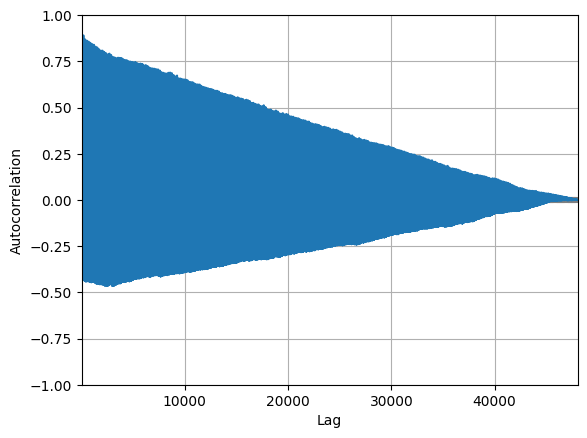

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df1['nat_demand'])
pyplot.show()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


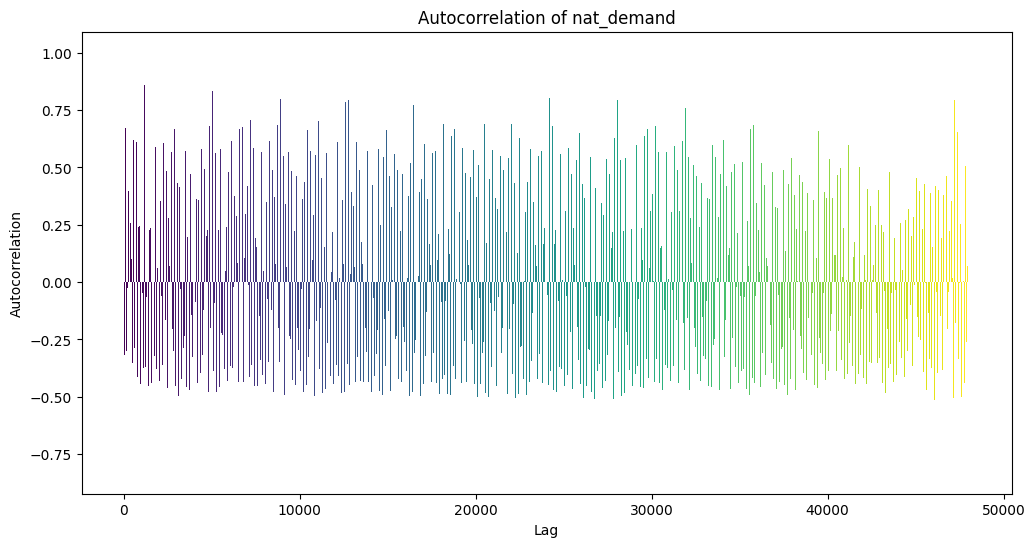

In [ ]:
# Generate the autocorrelation values
autocorrelation_values = [df1['nat_demand'].autocorr(lag) for lag in range(len(df1['nat_demand']))]

# Plot the autocorrelation with different colors for each lag
plt.figure(figsize=(12, 6))
plt.bar(range(len(autocorrelation_values)), autocorrelation_values, color=plt.cm.viridis(np.linspace(0, 1, len(autocorrelation_values))))
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of nat_demand')
plt.show()


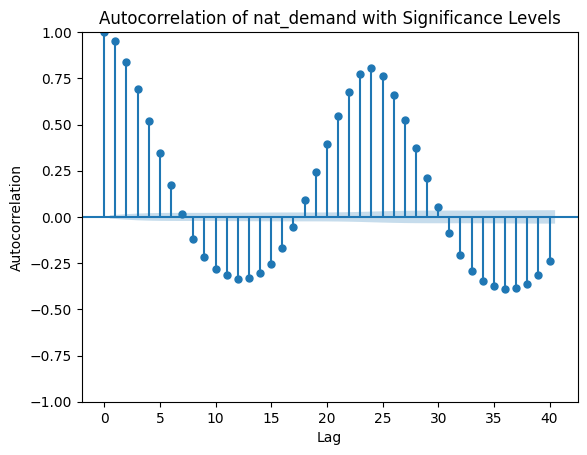

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Plot the autocorrelation function with significance levels
plot_acf(df1['nat_demand'], lags=40)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of nat_demand with Significance Levels')
plt.show()


**Graph Analysis** :

The graph displays the autocorrelation of 'nat_demand' at various lags, indicating the strength and direction of the relationship between each observation and its lagged value. The blue bars represent autocorrelation coefficients, with the 95% confidence intervals shown as horizontal lines. A significant autocorrelation beyond these intervals suggests a pattern. For example, a spike at lag 24 indicates a strong correlation between current demand and demand 24 hours prior, hinting at a daily seasonal trend.

In [ ]:
df2 = df1['nat_demand']

In [ ]:
from statsmodels.tsa.stattools import acf

# Calculate autocorrelation values
autocorr_values, confidence_intervals = acf(df1['nat_demand'], nlags=40, fft=False, alpha=0.05)

# Display autocorrelation values and confidence intervals
for lag, autocorr, (lower, upper) in zip(range(31), autocorr_values, confidence_intervals):
    print(f"Lag {lag}: Autocorrelation = {autocorr}, 95% Confidence Interval = [{lower}, {upper}]")


Lag 0: Autocorrelation = 1.0, 95% Confidence Interval = [1.0, 1.0]
Lag 1: Autocorrelation = 0.9513441405276984, 95% Confidence Interval = [0.9424026394425261, 0.9602856416128708]
Lag 2: Autocorrelation = 0.8386057596952933, 95% Confidence Interval = [0.8236167756293141, 0.8535947437612724]
Lag 3: Autocorrelation = 0.6896243550784675, 95% Confidence Interval = [0.6712634869672623, 0.7079852231896727]
Lag 4: Autocorrelation = 0.520276068226662, 95% Confidence Interval = [0.4999495481140617, 0.5406025883392622]
Lag 5: Autocorrelation = 0.3460003430572133, 95% Confidence Interval = [0.3246356399182122, 0.36736504619621435]
Lag 6: Autocorrelation = 0.1741423052113114, 95% Confidence Interval = [0.15233420414028648, 0.19595040628233634]
Lag 7: Autocorrelation = 0.014493311181016799, 95% Confidence Interval = [-0.0074256840822475734, 0.03641230644428117]
Lag 8: Autocorrelation = -0.11925237611350326, 95% Confidence Interval = [-0.14117213755157512, -0.09733261467543139]
Lag 9: Autocorrelation

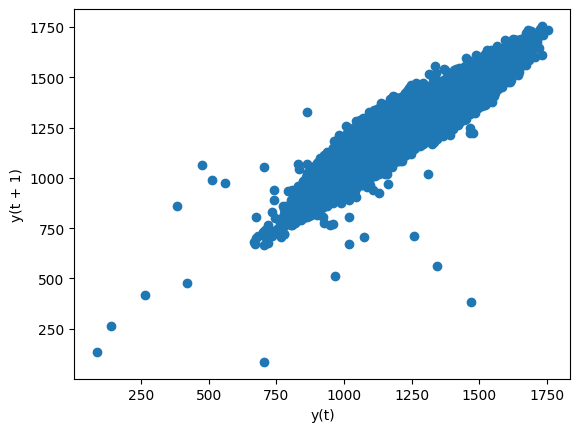

In [ ]:
from pandas.plotting import lag_plot

lag_plot(df2)
pyplot.show()


In [ ]:
from pandas import DataFrame
from pandas import concat
values = DataFrame(df2.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.951364
t+1  0.951364  1.000000


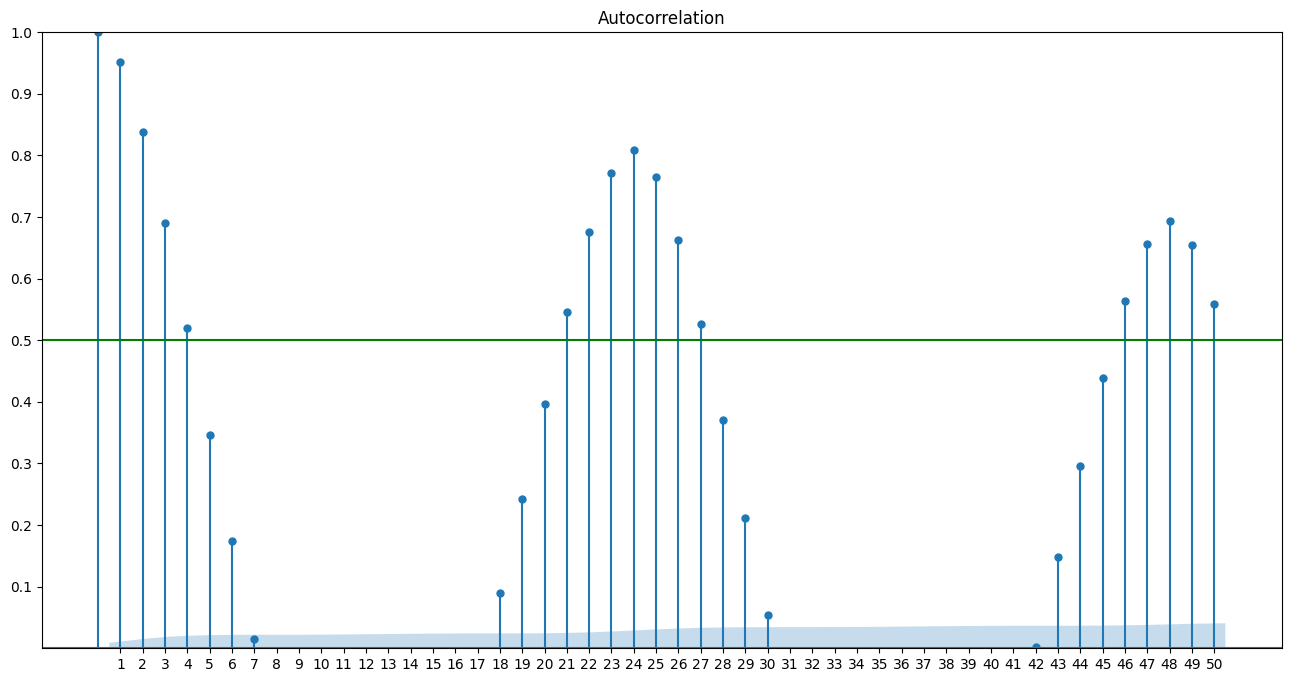

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(16,8))
plot_acf(df2, lags=50, ax=ax)
plt.ylim([0,1])
plt.yticks(np.arange(0.1, 1.1, 0.1))
plt.xticks(np.arange(1, 51, 1))
plt.axhline(y=0.5, color="green")
plt.show()

# **Persistence Model, Static Autoregressive Model and Static Autoregressive Model Analysis:**




Test MSE: 931.311


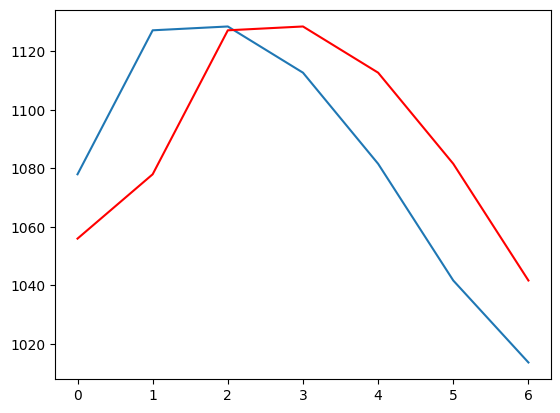

In [ ]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
# create lagged dataset
values = DataFrame(df2.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
	return x

# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

Coefficients: [ 4.13663834e+01  1.34124641e+00 -3.77557536e-01  2.53764676e-02
 -5.94978255e-02  2.64870559e-02  8.62546728e-03 -7.01904340e-02
  2.28376033e-02 -3.86126314e-02  8.09382942e-02  3.11593723e-02
 -1.35807411e-01  1.39236577e-01 -7.38007924e-02 -3.45814974e-02
  2.28829141e-02 -2.21390143e-02  7.48793550e-02 -2.64726015e-02
 -3.19848212e-02  5.53560504e-02 -8.49618119e-02  1.81639376e-01
  4.39410699e-01 -6.69057412e-01  4.46200703e-02  1.16149631e-01
 -5.51722614e-02  3.40236157e-02]
predicted=1096.386794, expected=1077.975600
predicted=1177.927346, expected=1127.249100
predicted=1198.407161, expected=1128.559200
predicted=1192.478349, expected=1112.748800
predicted=1174.204599, expected=1081.568000
predicted=1141.669363, expected=1041.624000
predicted=1093.511673, expected=1013.568300
Test RMSE: 74.761


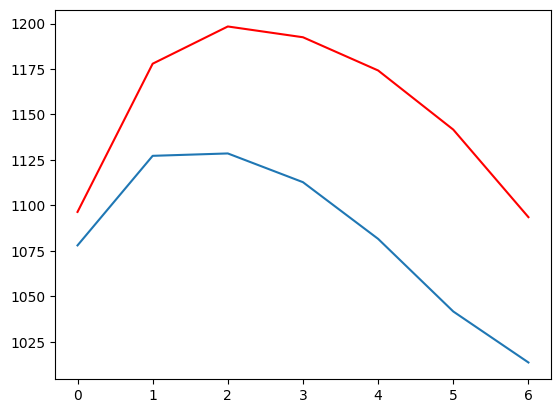

In [ ]:
# create and evaluate a static autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
# split dataset
X = df2.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AutoReg(train, lags=29)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

predicted=1096.386794, expected=1077.975600
predicted=1153.233397, expected=1127.249100
predicted=1137.386431, expected=1128.559200
predicted=1117.461764, expected=1112.748800
predicted=1093.448643, expected=1081.568000
predicted=1048.278441, expected=1041.624000
predicted=994.933260, expected=1013.568300
Test RMSE: 15.339


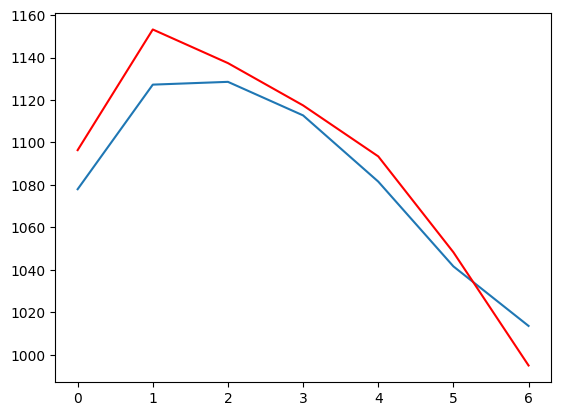

In [ ]:
# create and evaluate an updated autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
# split dataset
X = df2.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
window = 29
model = AutoReg(train, lags=29)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

**Graph explained** : With a test RMSE of 15.339, the updated autoregressive model demonstrates significantly improved predictive power compared to the other models. By incorporating more recent information into its predictions, the model captures the evolving nature of seasonal patterns and variations in electricity consumption more effectively. This highlights the importance of dynamic modeling approaches in time series forecasting, especially when dealing with complex and evolving datasets.

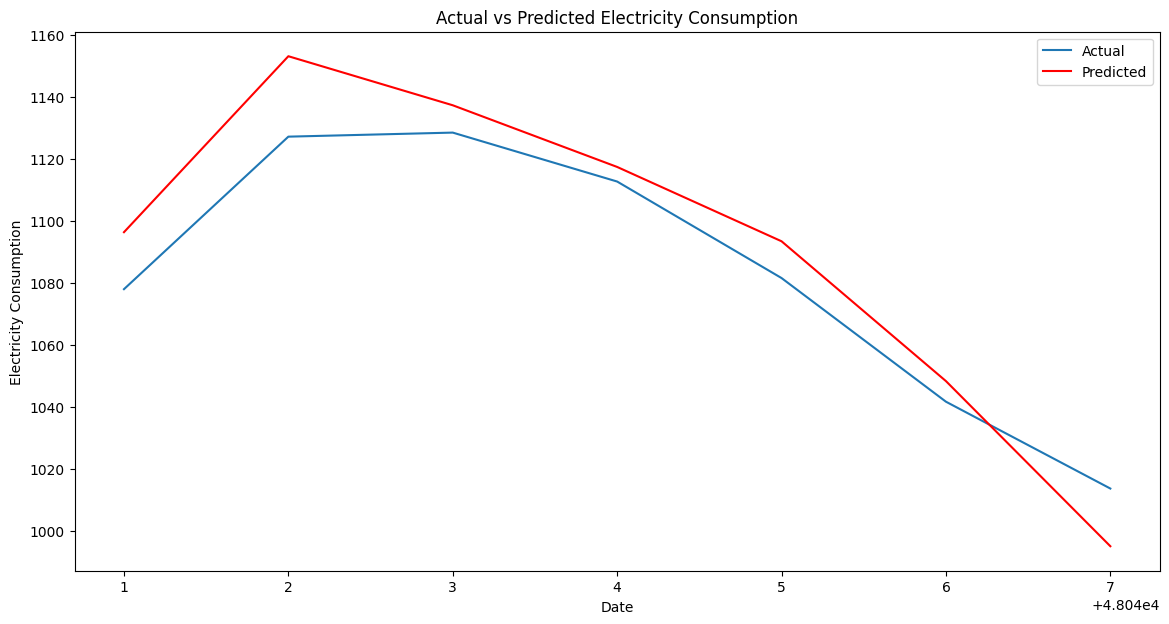

In [ ]:
from matplotlib import pyplot as plt

# Plot actual values
plt.figure(figsize=(14, 7))
plt.plot(df2.index[-len(test):], test, label='Actual')

# Plot predicted values
plt.plot(df2.index[-len(test):], predictions, label='Predicted', color='red')

plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.title('Actual vs Predicted Electricity Consumption')
plt.legend()
plt.show()


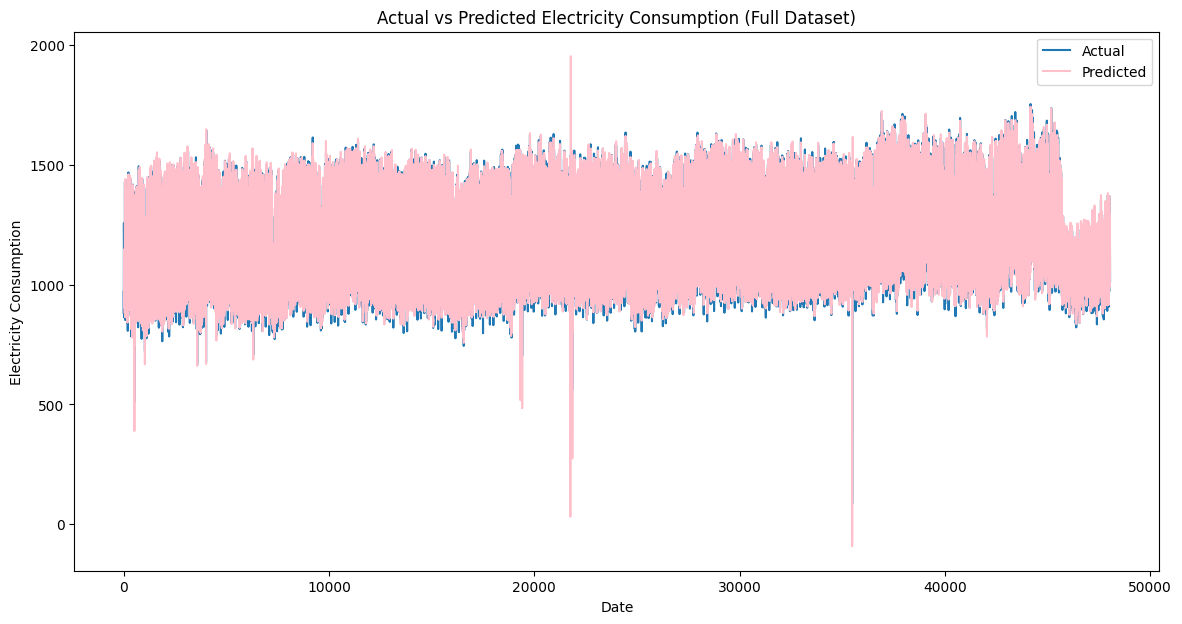

In [ ]:
# Plot actual values
plt.figure(figsize=(14, 7))
plt.plot(df2.index, df2.values, label='Actual')

# Predict values for the entire dataset
predictions_full = model_fit.predict(start=1, end=len(df2)-1, dynamic=False)

# Plot predicted values
plt.plot(df2.index[1:], predictions_full, label='Predicted', color='pink')

plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.title('Actual vs Predicted Electricity Consumption (Full Dataset)')
plt.legend()
plt.show()


**In conclusion**, the analysis of autoregressive models, including the persistence, static autoregressive, and updated autoregressive models, offers valuable insights into seasonal patterns in electricity consumption. The persistence model, though simple, provides a foundational understanding of seasonal trends but lacks the ability to capture the data's complexity, as seen in its high mean squared error (MSE). The static autoregressive model improves upon this by incorporating lagged values, providing a more nuanced view of how past observations influence future predictions. However, its static nature limits its adaptability to changing patterns over time.
The updated autoregressive model, with its dynamic approach to updating coefficients, outperforms both previous models. By incorporating recent information, it adapts more effectively to changing patterns, resulting in more accurate predictions. These models are crucial for energy providers, aiding in anticipating demand fluctuations, optimizing resource allocation, and ensuring a reliable electricity supply.
